In [1]:
import afqinsight as afq

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.regularizers import l1_l2, l2
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
import kerastuner as kt

In [3]:
pwd

'/Users/ceciliabarnes/Documents/DIRECT/afq-cnn/notebooks'

In [4]:
X, y, groups, feature_names, group_names, subjects, classes = afq.datasets.load_afq_data(
    workdir="../data/raw/cam-can",
    dwi_metrics=["dki_md", "dki_fa"],
    target_cols=["age"],
    index_col="Observations",
    fn_nodes="combined_tract_profiles.csv",
    fn_subjects="participant_data.tsv",
)

In [5]:
X.shape, y.shape

((641, 3600), (641,))

In [6]:
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
np.count_nonzero(np.isnan(y_test))

0

In [9]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
#y_imp = SimpleImputer(strategy='median')
#y_imp.fit(y_train)
#y_train = imp.transform(y_train)
#y_test = imp.transform(y_test)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((480, 3600), (480,), (160, 3600), (160,))

In [21]:
X_train_reshaped = np.swapaxes(X_train.reshape((480, 36, 100)), 1, 2)
X_test_reshaped = np.swapaxes(X_test.reshape((160, 36, 100)), 1, 2)

In [22]:
X_train.shape, X_test.shape

((480, 3600), (160, 3600))

In [23]:
def cam_can_model_builder(hp):
    model = Sequential()

    # input: 3+D tensor with shape: batch_shape + (steps, input_dim)
    # output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
    model = Sequential()
    
    filters1 = hp.Int('filters1', min_value=32, max_value=512, step=32)
    model.add(Dense(filters1, activation='relu', 
                    input_shape=X_train_reshaped.shape[1:]))
    
    filters2 = hp.Int('filters2', min_value=32, max_value=512, step=32)
    kernel1 = hp.Int('kernel1', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters2, kernel_size=kernel1, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters3 = hp.Int('filters3', min_value=32, max_value=512, step=32)
    kernel2 = hp.Int('kernel2', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters3, kernel_size=kernel2, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters4 = hp.Int('filters4', min_value=32, max_value=512, step=32)
    kernel3 = hp.Int('kernel3', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters4, kernel_size=kernel3, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters5 = hp.Int('filters5', min_value=32, max_value=512, step=32)
    kernel4 = hp.Int('kernel4', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters5, kernel_size=kernel4, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters6 = hp.Int('filters6', min_value=32, max_value=512, step=32)
    kernel5 = hp.Int('kernel5', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters6, kernel_size=kernel5, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    filters7 = hp.Int('filters7', min_value=32, max_value=512, step=32)
    model.add(Dense(filters7, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
    return model

In [26]:
cam_can_tuner = kt.Hyperband(cam_can_model_builder,
                     objective='mean_squared_error',
                     max_epochs=5,
                     factor=3)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [27]:
#callback = EarlyStopping(monitor='loss', patience=10)
cam_can_tuner.search(X_train_reshaped, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=cam_can_tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


In [17]:
cam_can_tuner.get_best_hyperparameters()[0].values

{'units1': 192,
 'units2': 122,
 'units3': 262,
 'units4': 332,
 'units5': 374,
 'units6': 1,
 'units7': 206,
 'units8': 4,
 'units9': 290,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [17]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = cam_can_tuner.hypermodel.build(best_hps)
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_split=0.2)

mse_per_epoch = history.history['mean_squared_error']
best_epoch = mse_per_epoch.index(min(mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
12/12 [==============================] - 1s 74ms/step - loss: 3191.4615 - mean_squared_error: 3191.4615 - val_loss: 3162.3835 - val_mean_squared_error: 3162.3835
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 3136.6451 - mean_squared_error: 3136.6451 - val_loss: 2786.4329 - val_mean_squared_error: 2786.4329
Epoch 3/50
12/12 [==============================] - 0s 8ms/step - loss: 2381.0273 - mean_squared_error: 2381.0273 - val_loss: 1348.3407 - val_mean_squared_error: 1348.3407
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 915.5265 - mean_squared_error: 915.5265 - val_loss: 471.7397 - val_mean_squared_error: 471.7397
Epoch 5/50
12/12 [==============================] - 0s 9ms/step - loss: 568.2979 - mean_squared_error: 568.2979 - val_loss: 449.6156 - val_mean_squared_error: 449.6156
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 530.9675 - mean_squared_error: 530.9675 - val_loss: 356.6227 - val_mean_squ

In [18]:
#model.summary()

In [19]:
hypermodel = cam_can_tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train_reshaped, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/40
12/12 [==============================] - 1s 23ms/step - loss: 3298.1723 - mean_squared_error: 3298.1723 - val_loss: 3212.0691 - val_mean_squared_error: 3212.0691
Epoch 2/40
12/12 [==============================] - 0s 9ms/step - loss: 3164.7210 - mean_squared_error: 3164.7210 - val_loss: 2984.5693 - val_mean_squared_error: 2984.5693
Epoch 3/40
12/12 [==============================] - 0s 8ms/step - loss: 2687.5960 - mean_squared_error: 2687.5960 - val_loss: 1835.6149 - val_mean_squared_error: 1835.6149
Epoch 4/40
12/12 [==============================] - 0s 9ms/step - loss: 1289.6447 - mean_squared_error: 1289.6447 - val_loss: 495.1778 - val_mean_squared_error: 495.1778
Epoch 5/40
12/12 [==============================] - 0s 7ms/step - loss: 621.9527 - mean_squared_error: 621.9527 - val_loss: 433.6857 - val_mean_squared_error: 433.6857
Epoch 6/40
12/12 [==============================] - 0s 8ms/step - loss: 512.0238 - mean_squared_error: 512.0238 - val_loss: 356.5697 - val_mean_s

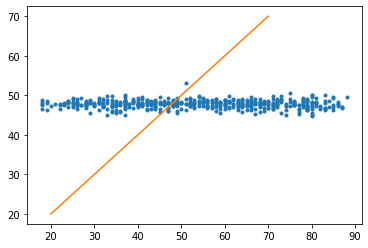

In [20]:
y_hat = hypermodel.predict(X_train_reshaped)
plt.plot(y_train, y_hat, linestyle="", marker=".")
plt.plot([20, 70], [20, 70])

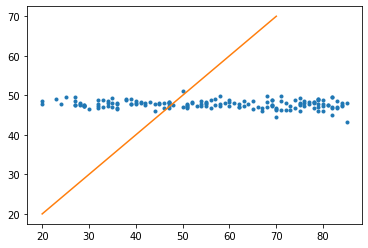

In [21]:
y_hat = hypermodel.predict(X_test_reshaped)
plt.plot(y_test, y_hat, linestyle="", marker=".")
plt.plot([20, 70], [20, 70])

In [22]:
r2_score(y_test, y_hat)

-0.23829178078955726